# **Data Cleaning**

## Objectives

* Evaluate missing data
* Clean data

## Inputs

* outputs/datasets/collection/HousePrices.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/PriceProphet-PP5/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/PriceProphet-PP5'

# Load Collected Data

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/HousePrices.csv")
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Data Exploration

In Data Cleaning you are interested to check the distribution and shape of a variable with missing data.

In [5]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [11]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df[vars_with_missing_data].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1374 non-null   float64
 1   BedroomAbvGr   1361 non-null   float64
 2   BsmtExposure   1422 non-null   object 
 3   BsmtFinType1   1315 non-null   object 
 4   EnclosedPorch  136 non-null    float64
 5   GarageFinish   1225 non-null   object 
 6   GarageYrBlt    1379 non-null   float64
 7   LotFrontage    1201 non-null   float64
 8   MasVnrArea     1452 non-null   float64
 9   WoodDeckSF     155 non-null    float64
dtypes: float64(7), object(3)
memory usage: 114.2+ KB


---

# Data Cleaning


## Assessing Missing Data Levels

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [6]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels for the collected dataset.

In [7]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,235,16.10,object
BsmtFinType1,145,9.93,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
BsmtExposure,38,2.60,object
MasVnrArea,8,0.55,float64


In conclusion, the missing data set contains varying percentages of missing values across different features. EnclosedPorch and WoodDeckSF have the highest percentage of missing data, followed by LotFrontage, GarageFinish, and BsmtFinType1. The remaining features have relatively low percentages of missing data. The data types of the features include both numerical (float64) and categorical (object) variables

# Handling Missing Data

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):
  """
  Function to visualize data cleaning effect
  """
  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

# Data Cleaning Summary

We use these method and imputations for data cleaning:
* Drop: 'EnclosedPorch', 'WoodDeckSF'
* Mean Imputation: 'LotFrontage' , 'BedroomAbvGr'
* Median Imputation: '2ndFlrSF' , 'GarageYrBlt', 'MasVnrArea']
* Categorical Imputation: 'GarageFinish', 'BsmtFinType1' and 'BsmtExposure'


# Split Train and Test Set

In [10]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet.head(3)

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
618,1828,0.0,NaN,Av,48,NaN,1774,NaN,774,Unf,...,90.0,452.0,108,5,9,1822,NaN,2007,2007,314813
870,894,0.0,2.0,No,0,Unf,894,NaN,308,NaN,...,60.0,0.0,0,5,5,894,NaN,1962,1962,109500
92,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,80.0,0.0,0,7,5,876,NaN,1921,2006,163500


We first check the number of variables in the train set with missing values to make sure that the split represents the whole dataset.

In [13]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 10 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,184,15.75,object
BsmtFinType1,114,9.76,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
BsmtExposure,28,2.40,object
MasVnrArea,6,0.51,float64


## Drop variables

* Variables to drop: ['EnclosedPorch', 'WoodDeckSF']
* We create a separate data frame applying the imputation method and assess the effect of this data cleaning step.
* List columns of the new data frame to see if the variables have beed dropped.

In [11]:
from feature_engine.selection import DropFeatures

variables_to_drop=['EnclosedPorch' , 'WoodDeckSF']
imputer = DropFeatures(features_to_drop=variables_to_drop)
df_method = imputer.fit_transform(TrainSet)

for i in variables_to_drop:
    print(i in df_method.columns.to_list())

False
False


## 2. Mean Imputation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr'] 




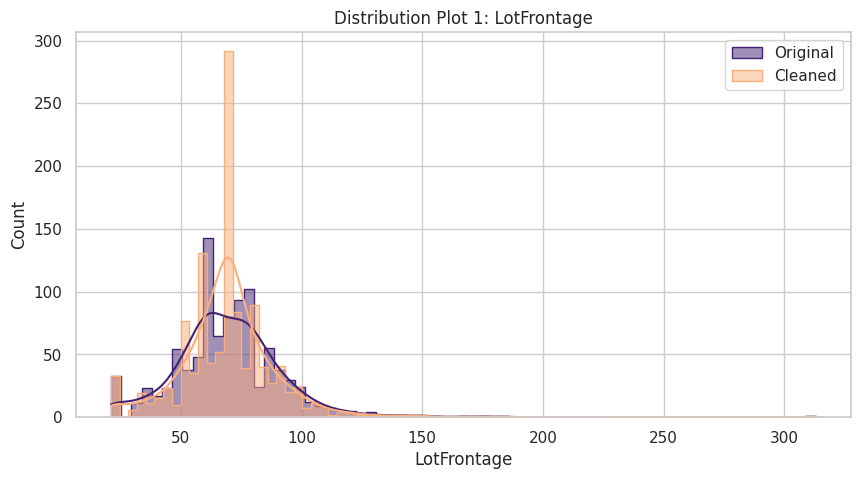

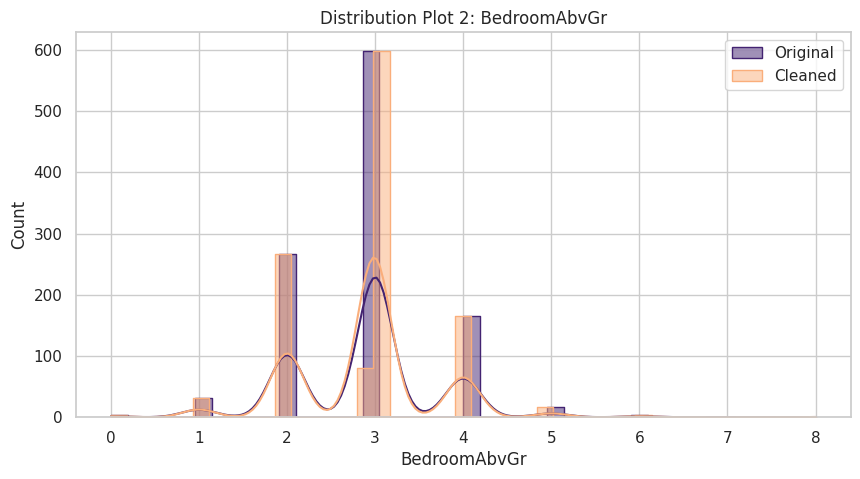

In [12]:
from feature_engine.imputation import MeanMedianImputer

variables_mean = ['LotFrontage' , 'BedroomAbvGr']
imputer = MeanMedianImputer(imputation_method='mean', variables=variables_mean)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_mean)

## 3. Median Imputation


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['2ndFlrSF', 'GarageYrBlt', 'MasVnrArea'] 




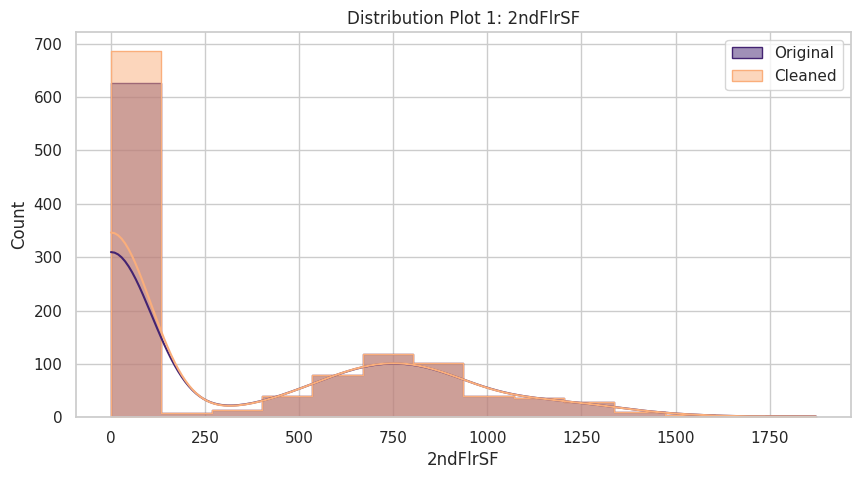

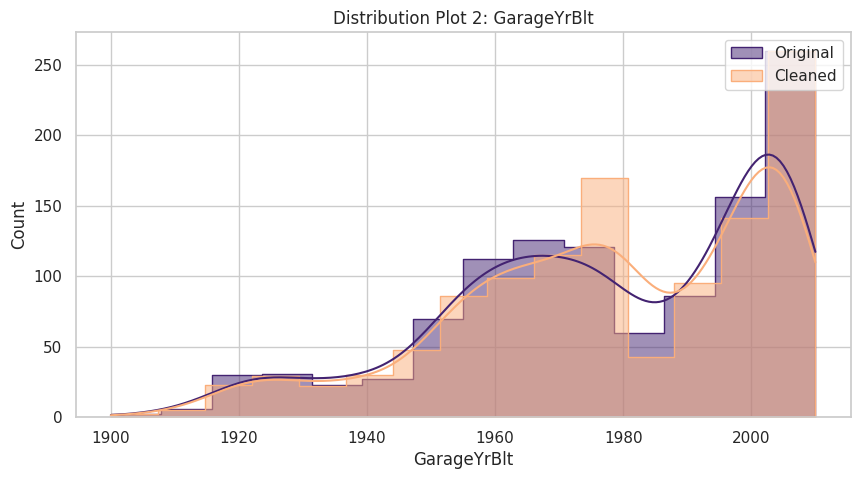

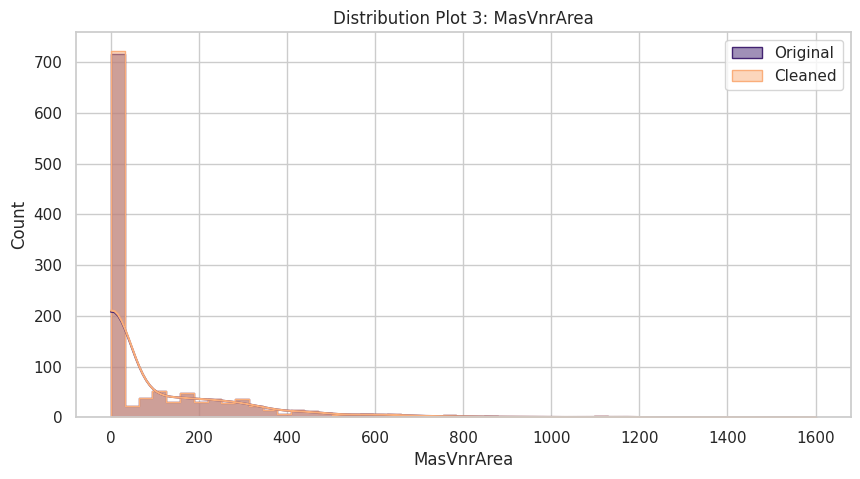

In [13]:
variables_median = ['2ndFlrSF' , 'GarageYrBlt', 'MasVnrArea']
imputer = MeanMedianImputer(imputation_method='median', variables=variables_median)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_median)

The below data shows where GarageYrBlt is NaN, GarageArea is zero.
Intuitively, the size of the garage is likely to have more effect on sales price than its age. So we can consider dropping GarageYrBlt.

In [15]:
TrainSet[(TrainSet['GarageArea'] ==0)][['GarageYrBlt', 'GarageArea']]

,GarageYrBlt,GarageArea
431,NaN,0
638,NaN,0
1337,NaN,0
528,NaN,0
960,NaN,0
1011,NaN,0
1283,NaN,0
1038,NaN,0
165,NaN,0
1349,NaN,0


## 4. Categorical Imputation

Variables: ['GarageFinish' , 'BsmtFinType1', 'BsmtExposure']


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1', 'BsmtExposure'] 




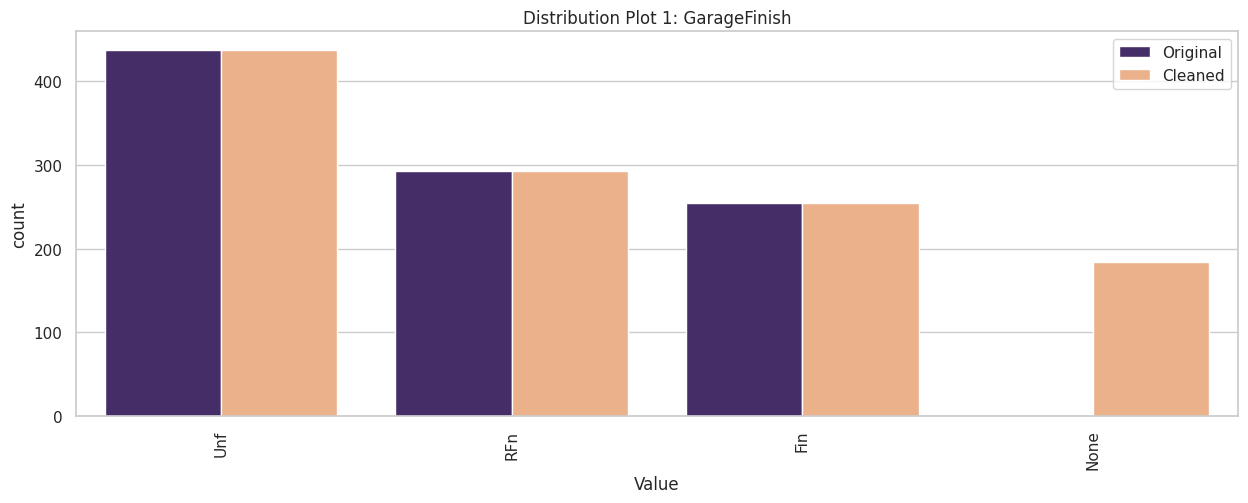

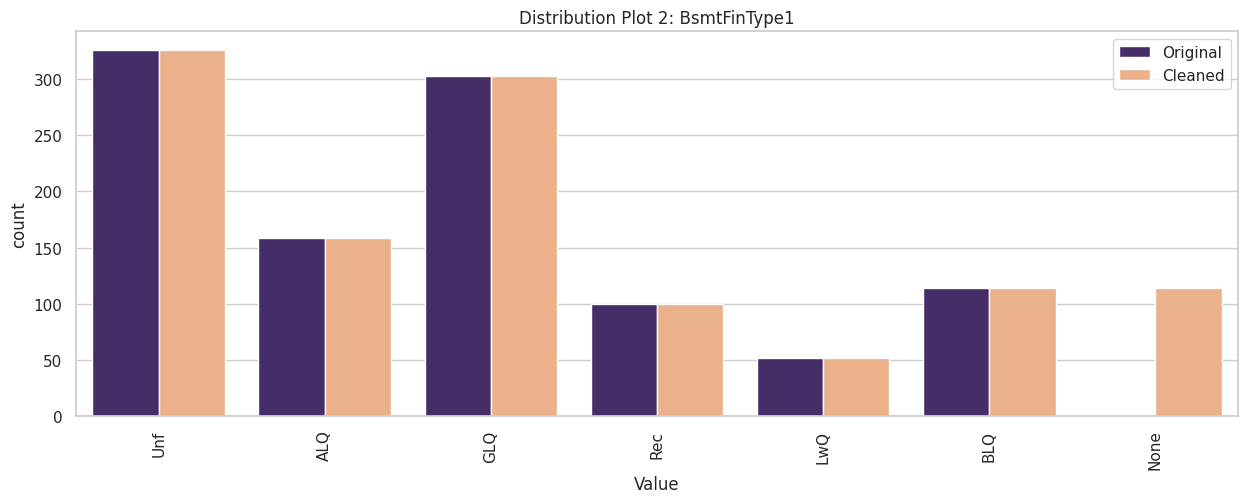

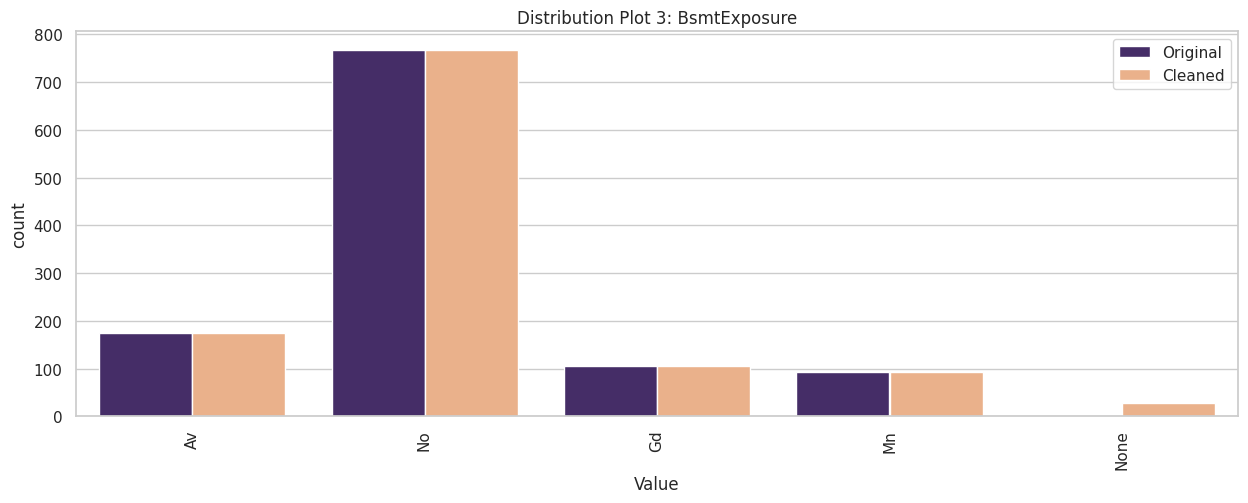

In [14]:
from feature_engine.imputation import CategoricalImputer

variables_categorical = ['GarageFinish' , 'BsmtFinType1', 'BsmtExposure']
imputer = CategoricalImputer(imputation_method='missing', fill_value='None', variables=variables_categorical)
df_method = imputer.fit_transform(TrainSet)
DataCleaningEffect(df_original=TrainSet,
                   df_cleaned=df_method,
                   variables_applied_with_method=variables_categorical)


In [19]:
TrainSet[(TrainSet['GarageArea'] ==0)][['GarageFinish', 'GarageArea']]

,GarageFinish,GarageArea
431,NaN,0
638,NaN,0
1337,NaN,0
528,NaN,0
960,NaN,0
1011,NaN,0
1283,NaN,0
1038,NaN,0
165,NaN,0
1349,NaN,0


The below data shows where 'TotalBsmtSF' is zero, 'BsmtFinType1' and 'BsmtExposure' is NaN.

In [20]:
TrainSet[(TrainSet['TotalBsmtSF'] ==0)][['TotalBsmtSF','BsmtFinType1', 'BsmtExposure']]

,TotalBsmtSF,BsmtFinType1,BsmtExposure
156,0,NaN,NaN
646,0,NaN,NaN
259,0,NaN,NaN
984,0,NaN,NaN
1011,0,NaN,NaN
553,0,NaN,NaN
1045,0,NaN,NaN
371,0,NaN,NaN
533,0,NaN,NaN
1412,0,NaN,NaN


# Data Cleaning Pipeline

We organize all the data cleaning steps we want to use in a single data cleaning pipeline.

This pipeline has the following steps:

* Mean imputation: variables=['LotFrontage' , 'BedroomAbvGr']
* Median imputation: variables=['2ndFlrSF', 'MasVnrArea']
* categorical imputation: variables=['GarageFinish' , 'BsmtFinType1', 'BsmtExposure']
* Dropping variables: features_to_drop=['EnclosedPorch', 'GarageYrBlt', 'WoodDeckSF']

In [21]:
from sklearn.pipeline import Pipeline

dataCleaning_pipeline = Pipeline([
      ( 'mean',  MeanMedianImputer(imputation_method='mean',
                                     variables=['LotFrontage' , 'BedroomAbvGr']) ),
      ( 'median',  MeanMedianImputer(imputation_method='median',
                                     variables=['2ndFlrSF', 'MasVnrArea']) ),
      ( 'categorical',  CategoricalImputer(imputation_method='missing',
                                     fill_value='None',
                                     variables=['GarageFinish' , 'BsmtFinType1', 'BsmtExposure']) ),
      ( 'drop',  DropFeatures(features_to_drop=['EnclosedPorch', 'GarageYrBlt', 'WoodDeckSF']) )
])

Now we can apply the pipeline to the whole dataset to get cleaned data.

In [22]:
TrainSet, TestSet = dataCleaning_pipeline.fit_transform(TrainSet) , dataCleaning_pipeline.fit_transform(TestSet)

df = dataCleaning_pipeline.fit_transform(df)

EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType


In [23]:
EvaluateMissingData(TestSet)

,RowsWithMissingData,PercentageOfDataset,DataType


In [24]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType


Calling the function that evaluates missing data shows that we have effectively handled all missing data in our data, the Train, Test and original data sets.

# Push files to Repo

In [25]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)


[Errno 17] File exists: 'outputs/datasets/cleaned'


In [26]:
# Train Set
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

# Test Set
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)

# Cleaned Dataset
df.to_csv("outputs/datasets/cleaned/HousePricesCleaned.csv", index=False)

Save Data Cleaning Pipeline
We have to save the data cleaning pipeline for later use to clean inherited houses provided to us by our client.

In [27]:
import joblib

file_path = f'outputs/ml_pipeline/data_cleaning'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/data_cleaning'


In [28]:
joblib.dump(value=dataCleaning_pipeline, filename=f"{file_path}/dataCleaning_pipeline.pkl")

['outputs/ml_pipeline/data_cleaning/dataCleaning_pipeline.pkl']